In [32]:
import pickle
import json

In [2]:
import numpy as np

In [3]:
class Question_pair:
    def __init__(self, id, qid1, qid2, question1, question2, is_duplicate):
        self.id = id
        self.gid1 = qid1
        self.qid2 = qid2
        self.question1 = question1
        self.question2 = question2
        self.is_duplicate = False if is_duplicate is "0" else True
        
    def show(self):
        print ("id:", self.id,"gid1:", self.gid1,"qid2:", self.qid2,"question1:", self.question1,"question2:", self.question2,"is_duplicate:", self.is_duplicate,)
      
    def __str__(self):
        return ("id:", self.id,"gid1:", self.gid1,"qid2:", self.qid2,"question1:", self.question1,"question2:", self.question2,"is_duplicate:", self.is_duplicate,)
   

In [4]:
question = pickle.load(open( "./data/preprocessed.plk", "rb" ))

In [5]:
question[0].question1

'What is the step by step guide to invest in share market in india?'

In [6]:
stopwords = []
with open("utils/english_stop_words_with_questions.txt") as f:
    stopwords = [line.strip() for line in f.readlines()]

In [26]:
from pycorenlp import StanfordCoreNLP

def start_StanfordCoreNLP_get_properties(address):
    nlp = StanfordCoreNLP(address)
    properties={
          'annotators': 'tokenize,ssplit,pos,lemma',
          'outputFormat': 'json'
          }
    return nlp, properties
 
def call_StanfordCoreNLP(input_line, nlp, properties):
    if input_line is "":
        return input_line
    
    return nlp.annotate(input_line,properties=properties)
    
def procces_line(input_line, stopwords, nlp, properties):
    if input_line is "":
        return input_line
    
    output_line = ""
    tokens = nlp.annotate(input_line,properties=properties)['sentences'][0]['tokens']
    
    output_list = [x['lemma'].lower().strip() for x in tokens if x['lemma'].isalpha()]
    for lemma in output_list:
        output_line = output_line + (" " + lemma if lemma not in stopwords else "")
    return output_line.strip()

def procces_line_with_no_call(output_of_nlp, stopwords):    
    output_line = ""
    tokens = output_of_nlp['sentences'][0]['tokens']
    
    output_list = [x['lemma'].lower().strip() for x in tokens if x['lemma'].isalpha()]
    for lemma in output_list:
        output_line = output_line + (" " + lemma if lemma not in stopwords else "")
    return output_line.strip()


In [27]:
nlp, properties = start_StanfordCoreNLP_get_properties('http://localhost:9000')

In [28]:
procces_line(input_line=question[0].question1, stopwords=stopwords, nlp=nlp ,properties=properties)

'step step guide invest share market india'

In [37]:
len(question)

404279

In [40]:
question_text1 = []
question_text2 = []
question_combination = []

are_duplicate = []

procesed_questions = []

for q in question:
    q1 = call_StanfordCoreNLP(input_line=q.question1, nlp=nlp ,properties=properties)
    q2 = call_StanfordCoreNLP(input_line=q.question2, nlp=nlp ,properties=properties)
    
#     collection = {"q1" : q1,
#                   "q2" : q2,
#                   "duplicate" : q.is_duplicate}
    
#     procesed_questions.append(collection)
    
    try:
        q1_lemma = procces_line_with_no_call(q1, stopwords= stopwords)
        q2_lemma = procces_line_with_no_call(q2, stopwords= stopwords)
    except:
        q1_lemma = q.question1
        q2_lemma = q.question2
    
    question_text1.append(q1_lemma)
    question_text2.append(q2_lemma)
    question_combination.append(q1_lemma + " " + q2_lemma)
    are_duplicate.append(q.is_duplicate)
    
#     if (len(procesed_questions) % 5000) == 0:
#         print ("=" , end='')
#         with open('./data/procesed_questions.json', 'w') as outfile:
#             json.dump(procesed_questions, outfile)
            

In [41]:
pickle.dump(question_text1, open( "./data/preprocessed_after_lemma1.plk", "wb" ))
pickle.dump(question_text2, open( "./data/preprocessed_after_lemma2.plk", "wb" ))

In [42]:
question_text1[5]

'astrology capricorn sun cap moon cap rise say'

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

words_train_tfidf = TfidfVectorizer(use_idf=True).fit(question_combination)

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
words_train_tfidf1 = words_train_tfidf.transform(question_text1)
words_train_tfidf2 = words_train_tfidf.transform(question_text2)

In [46]:
words_train_tfidf1.get_shape()

(404279, 65712)

In [47]:
words_train_tfidf2

<404279x65712 sparse matrix of type '<class 'numpy.float64'>'
	with 1981949 stored elements in Compressed Sparse Row format>

In [48]:
cosine_similarity(words_train_tfidf1[0], words_train_tfidf2[0])[0][0]

0.97995574719511569

In [49]:
cosine_similarities = []
for x in range(0,words_train_tfidf1.get_shape()[0]):
    cosine_similarities.append(cosine_similarity(words_train_tfidf1[x], words_train_tfidf2[x])[0][0])

In [50]:
np.mean(cosine_similarities)

0.54871308692436804

In [51]:
file_path = "./results/tf_idf_cosine_lemma.csv"

import csv
with open(file_path, 'a') as outcsv:   
    #configure writer to write standard csv file
    writer = csv.writer(outcsv, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['number'])
    for item in cosine_similarities:
        #Write item to outcsv
        writer.writerow([item])

In [52]:
from sklearn.metrics import average_precision_score
print (average_precision_score(are_duplicate, cosine_similarities))

0.572840809343


In [53]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

treshold = 0.1
step = 0.05

f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

tresholds = []

while treshold <= 0.91:
    print (treshold)
    
    f1_scores.append(f1_score(are_duplicate, [True if x > treshold else False for x in cosine_similarities]))
    precision_scores.append(precision_score(are_duplicate, [True if x > treshold else False for x in cosine_similarities]))
    recall_scores.append(recall_score(are_duplicate, [True if x > treshold else False for x in cosine_similarities]))
    accuracy_scores.append(accuracy_score(are_duplicate, [True if x > treshold else False for x in cosine_similarities]))    

    tresholds.append(treshold)
    treshold = treshold + step

0.1
0.15000000000000002
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7000000000000001
0.7500000000000001
0.8000000000000002
0.8500000000000002
0.9000000000000002


In [54]:
f1_scores

[0.58697088175959156,
 0.59241481338543422,
 0.5990749836280288,
 0.60556451106412379,
 0.61084858396953967,
 0.61563774616066391,
 0.61879731453632913,
 0.61965020927858716,
 0.61643726095512219,
 0.60827906976744195,
 0.59321801408463026,
 0.571318764412171,
 0.54293419887475125,
 0.50819636156158787,
 0.46633667738529661,
 0.41431503903738814,
 0.34777547916330437]

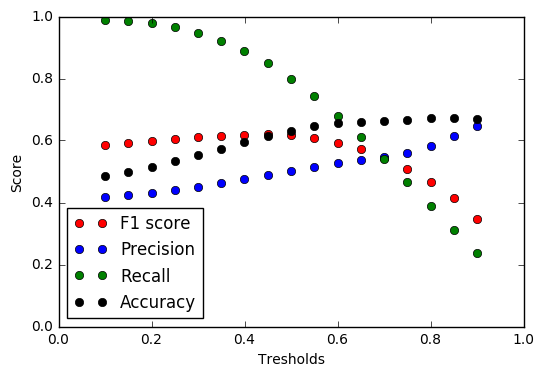

In [55]:
import matplotlib.pyplot as plt
plt.plot(tresholds, f1_scores, 'ro', label='F1 score')
plt.plot(tresholds, precision_scores, 'bo',label='Precision')
plt.plot(tresholds, recall_scores, 'go',label='Recall')
plt.plot(tresholds, accuracy_scores, 'ko',label='Accuracy')
#plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.xlabel("Tresholds")
plt.ylabel("Score")
plt.legend(loc=3)
plt.axis([0,1,0,1])
plt.show()